### Initialization

In [1]:
from mne.io import read_raw_eyelink
from mne.preprocessing.eyetracking import read_eyelink_calibration
from mne.viz.eyetracking import plot_gaze
import mne
import matplotlib.pyplot as plt
import numpy as np

### Plot gaze data

Loading /Users/baharsener/visualEyes/data/538mtlP1.asc
Pixel coordinate data detected.Pass `scalings=dict(eyegaze=1e3)` when using plot method to make traces more legible.
Pupil-size area detected.
Used Annotations descriptions: [np.str_('Block_1'), np.str_('Block_10'), np.str_('Block_2'), np.str_('Block_3'), np.str_('Block_4'), np.str_('Block_5'), np.str_('Block_6'), np.str_('Block_7'), np.str_('Block_8'), np.str_('Block_9'), np.str_('SYNCTIME'), np.str_('fixation'), np.str_('saccade')]
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
674 matching events found
No baseline correction applied
0 projection items activated
Reading calibration data from /Users/baharsener/visualEyes/data/538mtlP1.asc
Using data from preloaded Raw for 674 events and 351 original time points ...
384 bad epochs dropped


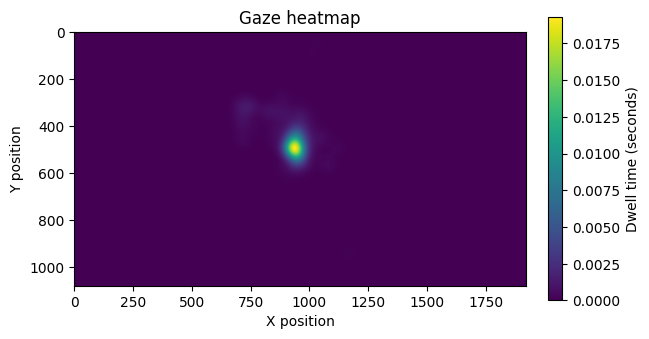

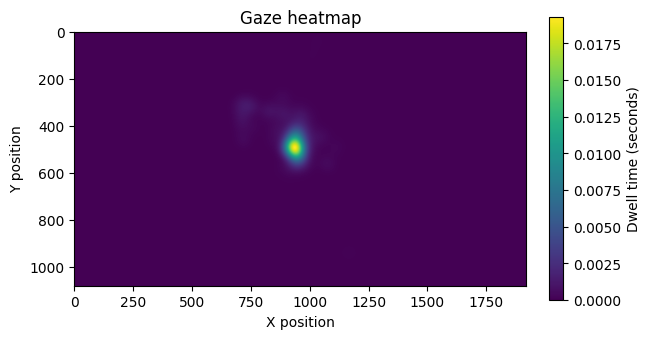

In [3]:
# Define file path
asc_file = '/Users/baharsener/visualEyes/data/538mtlP1.asc' # change this to the path of your file

# Read the raw data
raw_asc = read_raw_eyelink(asc_file)

# Define events
epochs = mne.Epochs(raw_asc, baseline=None)

# Retrieve the calibration data (will return empty list if no calibration was performed during the session)
calibration = read_eyelink_calibration(asc_file,
                                       screen_resolution=(1920, 1080),
                                       screen_size=(0.8013, 0.6984),
                                       screen_distance=1.2)[0]

#plotting all epochs, from brenda's previous code:
cmap = plt.get_cmap('viridis')
plot_gaze(epochs, calibration=calibration, cmap=cmap) #same plot

# TODO: how are bad epochs defined?

In [4]:
# some info of asc file
raw_asc
print(raw_asc.info['ch_names']) #I don't need the pupil right now but will use the gaze x and y. 
print(raw_asc.annotations)

['xpos_right', 'ypos_right', 'pupil_right']
<Annotations | 793 segments, channel-specific: BAD_blink (119), Block_1 ...>


In [5]:
# calibration info
calibration 

#might be good to add something here for people to set a threshold for good calibration!
#e.g., we might be able to infer whether the participant was not following instructions or calibration was bad

Calibration |
  onset: -3.988 seconds
  model: HV5
  eye: right
  average error: 0.39 degrees
  max error: 0.75 degrees
  screen size: (0.8013, 0.6984) meters
  screen distance: 1.2 meters
  screen resolution: (1920, 1080) pixels

In [6]:
# epoch info
epochs

<Epochs | 290 events (all good), -0.2 – 0.5 s (baseline off), ~7 kB, data not loaded,
 np.str_('Block_1'): 1
 np.str_('Block_10'): 1
 np.str_('Block_2'): 1
 np.str_('Block_3'): 1
 np.str_('Block_4'): 1
 np.str_('Block_5'): 1
 np.str_('Block_6'): 0
 np.str_('Block_7'): 1
 np.str_('Block_8'): 1
 np.str_('Block_9'): 0
 and 3 more events ...>

It looks like epoch time is relative to event/trial onset, so Time range of -0.200 – 0.500 s would be sampling between 0.2s before to 0.5s after event onset. Every 'event' I believe has an annotation, (these have info like saccade, fixation, block), similar to 'message' in EyeLink. So these events are every message-- I will just look at the fixation events now.

In [7]:
# TODO: what are the event counts?
#I want to see what is in my AOI vs out:
#get the annotations 
events, _ = mne.events_from_annotations(raw_asc)
print(events)

#looks like there is just one event per block, so I'm going to try to set an arbitrary AOI and get it for that:
#Gaze position: (these are 'channels' that were shown in epochs
gaze_x = raw_asc.get_data(picks="xpos_right")[0]
gaze_y = raw_asc.get_data(picks="ypos_right")[0] 

#random AOI coordinates (I just made this up)
aoi_x_min = 839
aoi_x_max = 1082
aoi_y_min = 462
aoi_y_max = 619

#drawing my AOI to count what fixations are within
within_aoi = (gaze_x >= aoi_x_min) & (gaze_x <= aoi_x_max) & \
             (gaze_y >= aoi_y_min) & (gaze_y <= aoi_y_max)

#initialize counters
fix_within = 0
fix_outside = 0

#Check if fixation is within AOI, count if it is or if it isn't
for event in events:
    if 'fixation' in raw_asc.annotations.description[event[2]]:  #check if message is "fixation"
        event_index = event[0] #get the index

        #Is the gaze position is within the AOI?
        if within_aoi[event_index]:
            fix_within += 1
        else:
            fix_outside += 1

print(fix_within)
print(fix_outside)


Used Annotations descriptions: [np.str_('Block_1'), np.str_('Block_10'), np.str_('Block_2'), np.str_('Block_3'), np.str_('Block_4'), np.str_('Block_5'), np.str_('Block_6'), np.str_('Block_7'), np.str_('Block_8'), np.str_('Block_9'), np.str_('SYNCTIME'), np.str_('fixation'), np.str_('saccade')]
[[     2      0     12]
 [    22      0     11]
 [    38      0     13]
 ...
 [113364      0     12]
 [113472      0     13]
 [113480      0     12]]
132
204


Now you can interpret whether this is normal/expected/desired. This should ideally be done per block in the case you want to exclude specific blocks. Perhaps the participant has some blocks they did well in and some where they were distracted. I didn't see a specific AOI function so I used this loop (also to understand the events better)

For comparing different packages: sample one data point every second, and plot all sampled data points together.

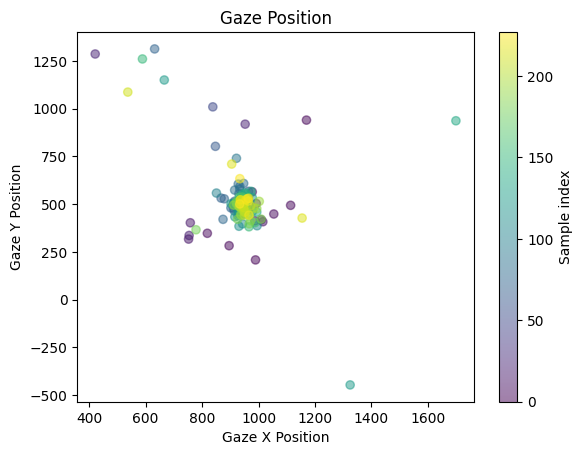

In [9]:
#sampling frequency is at 500 hz, so one sample every 2 ms:
sfreq = 500 #every 500th sample would be at one second
gaze_x = raw_asc.get_data(picks="xpos_right")[0] #same as when I was looking at the AOI
gaze_y = raw_asc.get_data(picks="ypos_right")[0] 

#Get every 500th sample from both:
sampled_x = gaze_x[::int(sfreq)]
sampled_y = gaze_y[::int(sfreq)] 

#basic scatter plot with color map that Brenda intitially used:
cmap = plt.get_cmap('viridis')
plt.scatter(sampled_x, sampled_y, c=np.arange(len(sampled_x)), cmap=cmap, marker='o', alpha=0.5)
plt.colorbar(label='Sample index') #so we get some time info
plt.xlabel('Gaze X Position')
plt.ylabel('Gaze Y Position')
plt.title('Gaze Position')
plt.show()

Some comments from Bahar:
I overall found this package a little difficult to navigate and like it might have a somewhat steep learning curve. I believe that the ideal user for this tool is a researcher who does not only look at eye-tracking, but combines eye-tracking with other neural data such as EEG/MEG. I know Brenda also uses fMRI so perhaps she can weigh in on this better than I can. 

My reasoning mainly comes from me working through the introductory tutorials for this package and finding a lot of information and tutorials, I had to spend a good amount of time sorting through information to find what would be applicable. I had to read through 4-5 different tutorial pages to be able to work through this notebook and fill in our to-do's. The "Working with eye tracker data in MNE-Python" tutorial, for example, goes through an example for which there was eye-tracking along with EEG, so I had to 'filter' the information to understand what would be relevant to me. I appreciate that there are so many tutorials available, but for my purposes, and for our user's purposes, the need is perhaps a simpler quality control, to see if a participant is following task instructions, or if a data file should be included in the final analysis. 

I believe a more "straightforward" package, i.e., something that would be easy to use after looking through the README on GitHub, will be more appropriate for our users. This may also be better to accomodate users from a variety of levels of experience/expertise. I am happy to discuss if anyone has other perspectives and if there are other factors I may not be accounting for in my reasoning!